<a href="https://colab.research.google.com/github/DilemmaFixer3/3D_lab10/blob/main/lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Figure size 700x900 with 0 Axes>

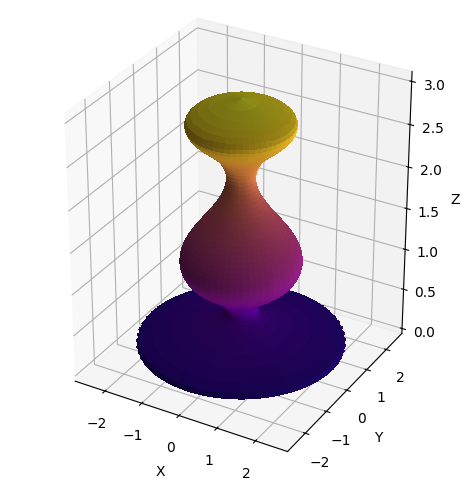

OBJ+MTL збережено в: output/vase.obj, output/vase.mtl
PLY збережено в: output/vase.ply


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from matplotlib import cm
import os

# --- Налаштування шляхів для Colab ---
# Створюємо директорію 'output' для зберігання всіх файлів
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

obj_path = os.path.join(output_dir, "vase.obj")
mtl_path = os.path.join(output_dir, "vase.mtl")
ply_path = os.path.join(output_dir, "vase.ply")
preview_path = os.path.join(output_dir, "vase_preview.png")

# --- 1. Профіль вази ---
# control_points: [радіус, висота]
# Вид спереду дає профіль (радіус vs висота)
# Змініть ці точки для відповідності Вашому ескізу [cite: 5, 9]
control_points = np.array([
    [0.00, 0.00],  # Дно (центр)
    [1.10, 0.05],  # Край дна
    [1.40, 0.30],  # Найширша частина внизу
    [1.15, 0.90],
    [0.90, 1.60],
    [0.60, 2.40],
    [0.30, 3.00],
    [0.00, 3.05]   # Горловина (центр)
]) # [cite: 32, 48]

r_pts, z_pts = control_points[:, 0], control_points[:, 1]
order = np.argsort(z_pts)
z_pts, r_pts = z_pts[order], r_pts[order] # Сортування за висотою [cite: 49, 50]

# --- 2. Побудова профілю ---
nz, ntheta = 200, 180 # Роздільність (nz - вертикально, ntheta - кутово) [cite: 53, 13]
z_lin = np.linspace(z_pts[0], z_pts[-1], nz) # Лінійна сітка висоти [cite: 54, 56]

# Згладжування профілю за допомогою CubicSpline [cite: 6, 20]
cs = CubicSpline(z_pts, r_pts, bc_type='clamped') # [cite: 58]
r_lin = np.clip(cs(z_lin), 0.0, None) # Радіуси профілю (обмежуємо від'ємні) [cite: 60]

# Обертання профілю навколо осі Z
theta = np.linspace(0, 2 * np.pi, ntheta) # Кутова сітка [cite: 60]
Z, Theta = np.meshgrid(z_lin, theta) # Створення сітки [cite: 60]
R = np.tile(r_lin, (ntheta, 1)) # Радіуси для кожної точки кута [cite: 60]

# Перехід у декартові координати
X = R * np.cos(Theta) # [cite: 61]
Y = R * np.sin(Theta) # [cite: 61]

# --- 3. Кольори (Градієнт за висотою) ---
cmap = cm.plasma # [cite: 65]
# Нормалізація висоти (Z) для визначення кольору
color_values = (Z - Z.min()) / (Z.max() - Z.min()) # [cite: 66, 68]
colors = cmap(color_values)[:, :, :3] # Отримання RGB кольорів [cite: 70]

# --- 4. Візуалізація ---
plt.figure(figsize=(7, 9)) # [cite: 72]
fig = plt.figure() # [cite: 74]
ax = fig.add_subplot(111, projection='3d') # [cite: 76]

# Побудова 3D-поверхні
ax.plot_surface(X, Y, Z, facecolors=colors, rstride=3, cstride=3,
                linewidth=0, antialiased=False) # [cite: 77, 78]

ax.set_xlabel('X') # [cite: 79]
ax.set_ylabel('Y') # [cite: 80]
ax.set_zlabel('Z') # [cite: 81]
ax.set_box_aspect([1, 1, Z.max() / R.max()]) # Збереження пропорцій [cite: 82]
plt.tight_layout() # [cite: 83]
plt.savefig(preview_path) # Збереження у нову папку 'output'
plt.show() # [cite: 84]

# --- 5. Генерація сітки (Вершини та грані) ---
verts = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()]) # Всі вершини [cite: 87]
faces = [] # [cite: 88]
rows, cols = ntheta, nz # [cite: 89]

def vid(i, j): return i * cols + j # Функція для індексування вершин [cite: 90]

# Створення граней (трикутників)
for i in range(rows): # Кутовий напрямок [cite: 91]
    inext = (i + 1) % rows
    for j in range(cols - 1): # Вертикальний напрямок [cite: 93]
        # Два трикутники для одного прямокутника сітки
        faces.append([vid(i, j), vid(inext, j), vid(inext, j + 1)]) # [cite: 94, 96]
        faces.append([vid(i, j), vid(inext, j + 1), vid(i, j + 1)]) # [cite: 95, 97]

faces = np.array(faces, dtype=int) # [cite: 98]
col = colors.ravel().reshape(-1, 3) # Кольори вершин

# --- 6. Експорт у OBJ+MTL ---
# Шляхи вже визначені на початку скрипта
obj_name = "vase"

with open(mtl_path, "w") as mtl:
    mtl.write("newmtl vase_material\nKd 1.0 1.0 1.0\n")

with open(obj_path, "w") as f:
    # Використовуємо тільки ім'я файлу MTL для посилання
    f.write(f"mtllib {os.path.basename(mtl_path)}\n")
    f.write(f"usemtl vase_material\n")

    for i, v in enumerate(verts):
        color = col[i]
        f.write(f"v {v[0]:.6f} {v[1]:.6f} {v[2]:.6f} {color[0]:.4f} {color[1]:.4f} {color[2]:.4f}\n")

    for face in faces:
        f.write(f"f {face[0] + 1} {face[1] + 1} {face[2] + 1}\n")

print(f"OBJ+MTL збережено в: {obj_path}, {mtl_path}")

# --- 7. Експорт у PLY ---
# Шлях вже визначений на початку скрипта
colors_uint8 = (colors * 255).astype(np.uint8)
verts_colors = np.hstack([verts, colors_uint8.reshape(-1, 3)])

with open(ply_path, "w") as f:
    f.write("ply\nformat ascii 1.0\n")
    f.write(f"element vertex {len(verts)}\n")
    f.write("property float x\nproperty float y\nproperty float z\n")
    f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
    f.write(f"element face {len(faces)}\n")
    f.write("property list uchar int vertex indices\n")
    f.write("end_header\n")

    for v in verts_colors:
        f.write(f"{v[0]} {v[1]} {v[2]} {v[3]} {v[4]} {v[5]}\n")

    for face in faces:
        f.write(f"3 {face[0]} {face[1]} {face[2]}\n")

print(f"PLY збережено в: {ply_path}")

# Виводимо прев'ю в кінці